# Jan 13th, 2021 (topo dist, best density)

**Motivation**: Applied to $128*0$ and $256*0$  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def collect_adjacencies(mice, mode):
    proc, *_ = mice.get_data_containers(mode)

    adjacencies, dirs = [], {}
    for key in proc:
        sub, ses, run = mice.looper[key]
        if run == -1:
            continue
        net = Network(mice, key, mode).load_network()
        adjacencies.append(np.expand_dims(net.adj, 0))
        dirs[key] = pjoin(mice.cfg.results_dir, 'Network', net.base_name)

    adjacencies = np.concatenate(adjacencies)
    return adjacencies, dirs


def calculate_portraits(adj, thres, save_dir=None):
    portraits = {}
    nonzero = np.abs(adj).mean(0) > 0
    for i, th in enumerate(thres):
        adj_eff = adj[nonzero][:, nonzero]
        adj_eff[adj_eff <= th] = 0.
        g = nx.from_numpy_matrix(adj_eff)
        if save_dir is not None:
            fname = f"{'_'.join(save_dir.split('_')[-3:])}_no{i:03d}_th{th:0.7f}"
        else:
            fname = None
        portraits[(i, th)] = portrait_cpp(g, fname)

    if save_dir is not None:
        save_obj(
            obj=portraits,
            file_name='portraits',
            save_dir=save_dir,
            mode='npy',
            verbose=False,
        )
    return portraits


def calculate_portrait_divergece(portraits_list):
    div = np_nans((len(portraits_list), len(portraits_list)))
    for i, j in itertools.combinations(range(len(portraits_list)), 2):
        div[i, j] = portrait_divergence(portraits_list[i], portraits_list[j])
    return div

In [3]:
sys.path.insert(0, pjoin(git_dir, 'network-portrait-divergence'))
from portrait_divergence import portrait_divergence, portrait_py, portrait_cpp

## 128*0

In [4]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

### Bold-lite

In [5]:
adjacencies, dirs = collect_adjacencies(mice, 'bold-lite')
adjacencies.shape

(114, 174, 174)

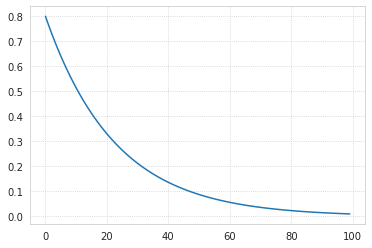

In [6]:
start = 0.80
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [7]:
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [9]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portraits)
        (adjacencies[i], thresholds[i], list(dirs.values())[i])
        for i in range(len(adjacencies))
    )

CPU times: user 1.35 s, sys: 2.39 s, total: 3.74 s
Wall time: 28 s


In [10]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [11]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    div_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portrait_divergece)
        ([v[di] for v in portraits.values()])
        for di in range(len(densities))
    )
    
div = np_nans((len(densities), len(adjacencies), len(adjacencies)))
for di in range(len(densities)):
    div[di] = div_list[di]

CPU times: user 1.18 s, sys: 2.47 s, total: 3.64 s
Wall time: 10.6 s


In [12]:
ses_ids_list = []
for key in dirs:
    sub, ses, run = mice.looper[key]
    ses_ids_list.append(ses)
ses_ids = {
    int(ses): np.where(ses_ids_list == ses)[0]
    for ses in np.unique(ses_ids_list)
}

In [13]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = []
    for v in across.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
    
    data = []
    for v in within.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
df1 = pd.DataFrame(merge_dicts(dlist))

In [14]:
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.3606397769158339, 0.33951806513020266)

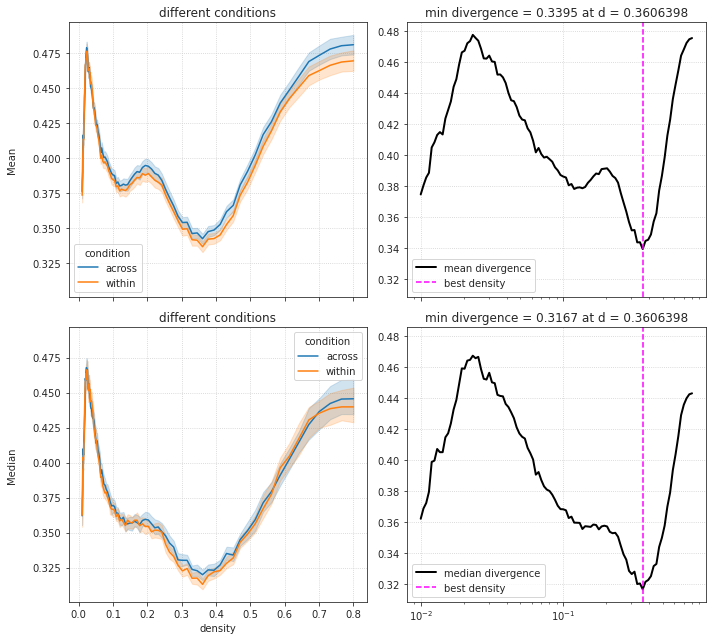

In [15]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df1.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [16]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: bn.nanmean(v) for k, v in across.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: bn.nanmean(v) for k, v in within.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df2 = pd.DataFrame(merge_dicts(dlist))

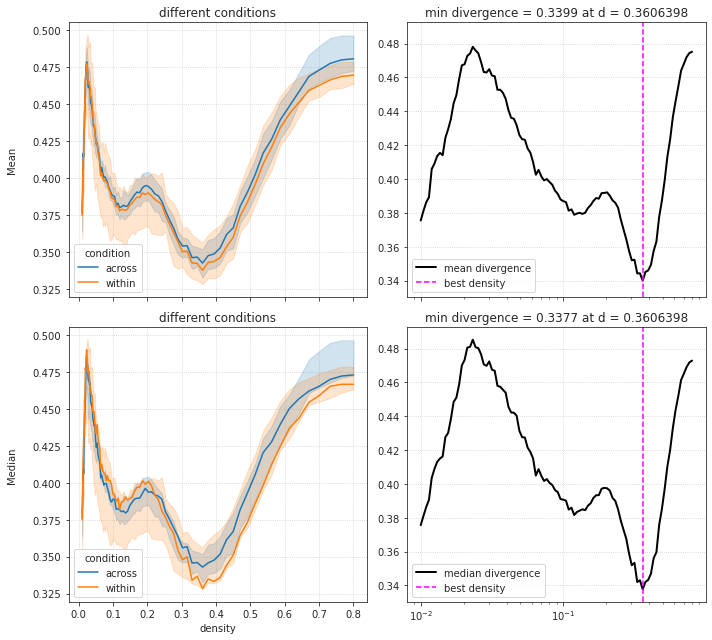

In [17]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df2.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [18]:
df_avg = df1.loc[df1['condition'] == 'within'].groupby(['density']).median()
# df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.3606397769158339, 0.3130570375164797)

In [19]:
df_avg = df2.loc[df2['condition'] == 'within'].groupby(['density']).median()
# df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.3606397769158339, 0.3284141933605381)

#### tSNE on distance matrix

In [20]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(18, 0.3606397769158339)

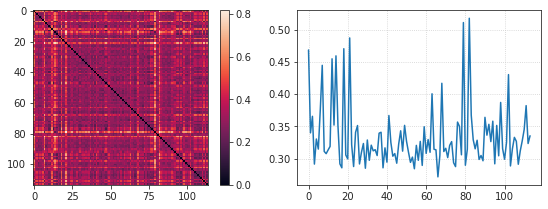

In [21]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(x.mean(0))
axes[1].grid()
plt.show()

In [22]:
bad_runs_bold = np.argsort(x.mean(0))[::-1][:10]
bad_runs_bold = [list(dirs)[i] for i in bad_runs_bold]
bad_runs_bold

[
    'sub-SLC08_ses-1_run-5',
    'sub-SLC07_ses-3_run-5',
    'sub-SLC02_ses-3_run-5',
    'sub-SLC02_ses-2_run-5',
    'sub-SLC01_ses-1_run-1',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC09_ses-3_run-7',
    'sub-SLC06_ses-3_run-7'
]

In [23]:
from sklearn.manifold import TSNE, MDS

In [24]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [25]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = ses_ids_list

<AxesSubplot:xlabel='x', ylabel='y'>

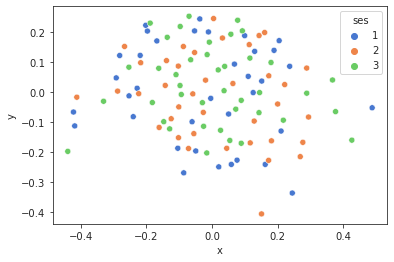

In [26]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

In [27]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [28]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

<AxesSubplot:xlabel='x', ylabel='y'>

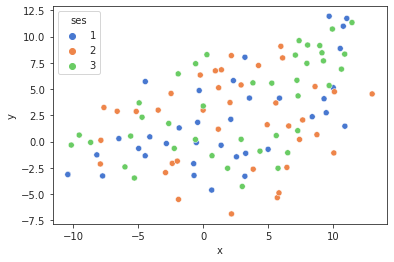

In [29]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

### Ca2

In [30]:
adjacencies, dirs = collect_adjacencies(mice, 'ca2')
adjacencies.shape

(118, 174, 174)

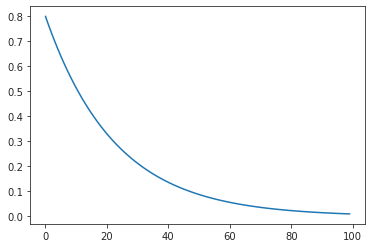

In [31]:
start = 0.80
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [32]:
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [34]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portraits)
        (adjacencies[i], thresholds[i], list(dirs.values())[i])
        for i in range(len(adjacencies))
    )

CPU times: user 1.22 s, sys: 2.68 s, total: 3.9 s
Wall time: 25 s


In [35]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [36]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    div_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portrait_divergece)
        ([v[di] for v in portraits.values()])
        for di in range(len(densities))
    )
    
div = np_nans((len(densities), len(adjacencies), len(adjacencies)))
for di in range(len(densities)):
    div[di] = div_list[di]

CPU times: user 1.15 s, sys: 2.78 s, total: 3.94 s
Wall time: 11.1 s


In [37]:
ses_ids_list = []
for key in dirs:
    sub, ses, run = mice.looper[key]
    ses_ids_list.append(ses)
ses_ids = {
    int(ses): np.where(ses_ids_list == ses)[0]
    for ses in np.unique(ses_ids_list)
}

In [38]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = []
    for v in across.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
    
    data = []
    for v in within.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
df1 = pd.DataFrame(merge_dicts(dlist))

In [39]:
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.39402147105325247, 0.32027876096374713)

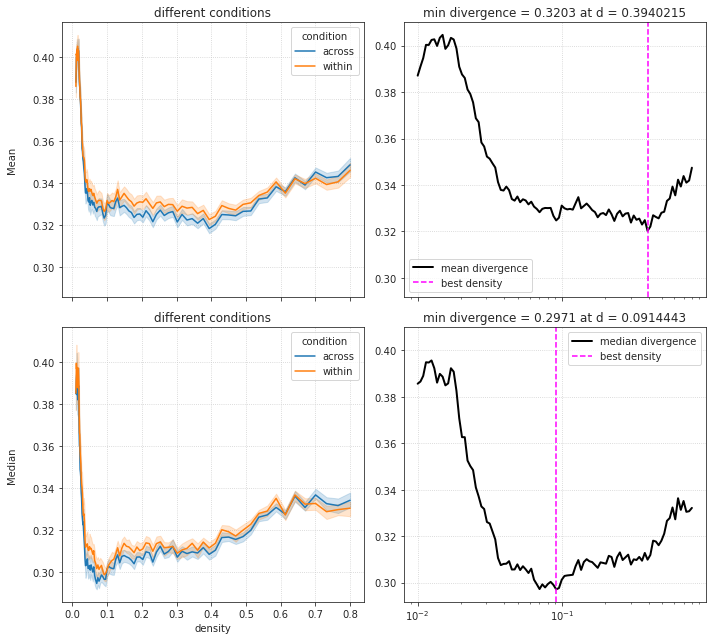

In [40]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df1.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [41]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: bn.nanmean(v) for k, v in across.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: bn.nanmean(v) for k, v in within.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df2 = pd.DataFrame(merge_dicts(dlist))

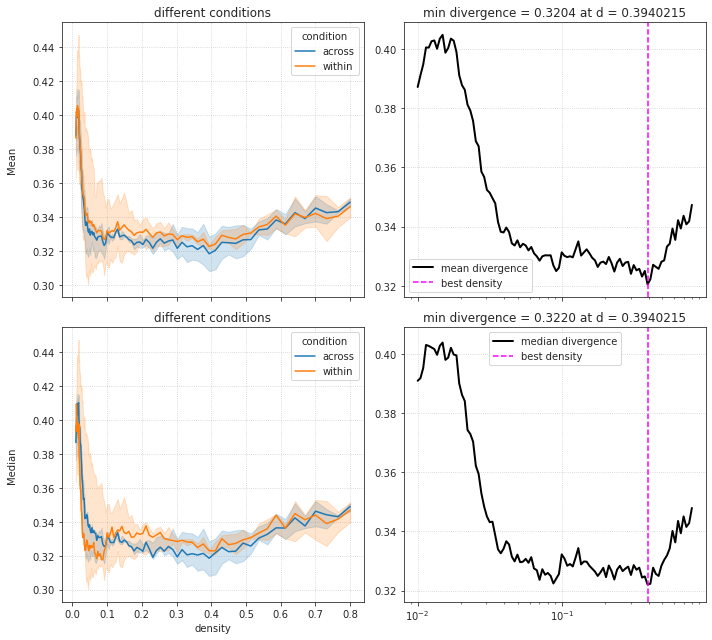

In [42]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df2.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [43]:
df_avg = df1.loc[df1['condition'] == 'within'].groupby(['density']).median()
# df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.09144428301222289, 0.2986153007680884)

In [44]:
df_avg = df2.loc[df2['condition'] == 'within'].groupby(['density']).median()
# df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.08369707807445692, 0.31767192658908755)

#### tSNE on distance matrix

In [45]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(51, 0.08369707807445692)

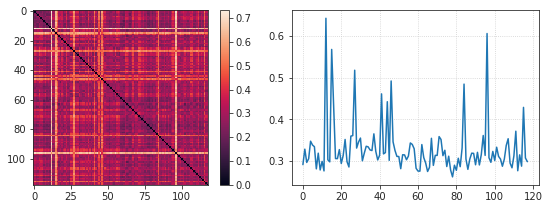

In [46]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(x.mean(0))
axes[1].grid()
plt.show()

In [47]:
bad_runs_bold = np.argsort(x.mean(0))[::-1][:10]
bad_runs_bold = [list(dirs)[i] for i in bad_runs_bold]
bad_runs_bold

[
    'sub-SLC02_ses-1_run-1',
    'sub-SLC09_ses-1_run-5',
    'sub-SLC02_ses-1_run-7',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC08_ses-1_run-3',
    'sub-SLC04_ses-2_run-5',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC10_ses-3_run-3'
]

In [48]:
from sklearn.manifold import TSNE, MDS

In [49]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [50]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = ses_ids_list

<AxesSubplot:xlabel='x', ylabel='y'>

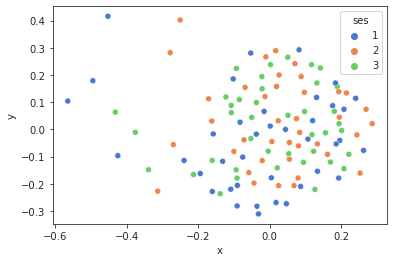

In [51]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

In [52]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [53]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

<AxesSubplot:xlabel='x', ylabel='y'>

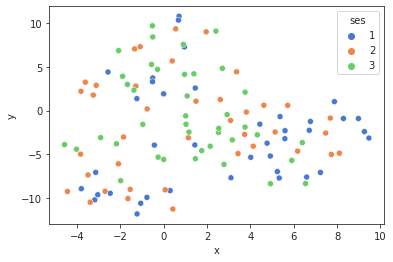

In [54]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

## 256*0

In [4]:
mice = Mice((256, 0, 100))
mice.setup_func_data('rest')

### Bold-lite

In [5]:
adjacencies, dirs = collect_adjacencies(mice, 'bold-lite')
adjacencies.shape

(114, 312, 312)

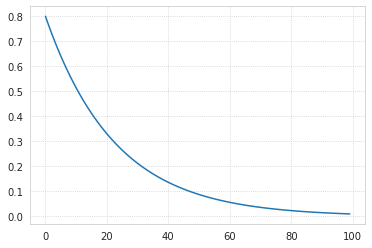

In [6]:
start = 0.80
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [8]:
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [9]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portraits)
        (adjacencies[i], thresholds[i], list(dirs.values())[i])
        for i in range(len(adjacencies))
    )

CPU times: user 2.09 s, sys: 2.69 s, total: 4.78 s
Wall time: 1min 42s


In [10]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [11]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    div_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portrait_divergece)
        ([v[di] for v in portraits.values()])
        for di in range(len(densities))
    )
    
div = np_nans((len(densities), len(adjacencies), len(adjacencies)))
for di in range(len(densities)):
    div[di] = div_list[di]

CPU times: user 1.39 s, sys: 2.52 s, total: 3.9 s
Wall time: 14.8 s


In [12]:
ses_ids_list = []
for key in dirs:
    sub, ses, run = mice.looper[key]
    ses_ids_list.append(ses)
ses_ids = {
    int(ses): np.where(ses_ids_list == ses)[0]
    for ses in np.unique(ses_ids_list)
}

In [13]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = []
    for v in across.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
    
    data = []
    for v in within.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
df1 = pd.DataFrame(merge_dicts(dlist))

In [14]:
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.345024944381573, 0.3467026251463687)

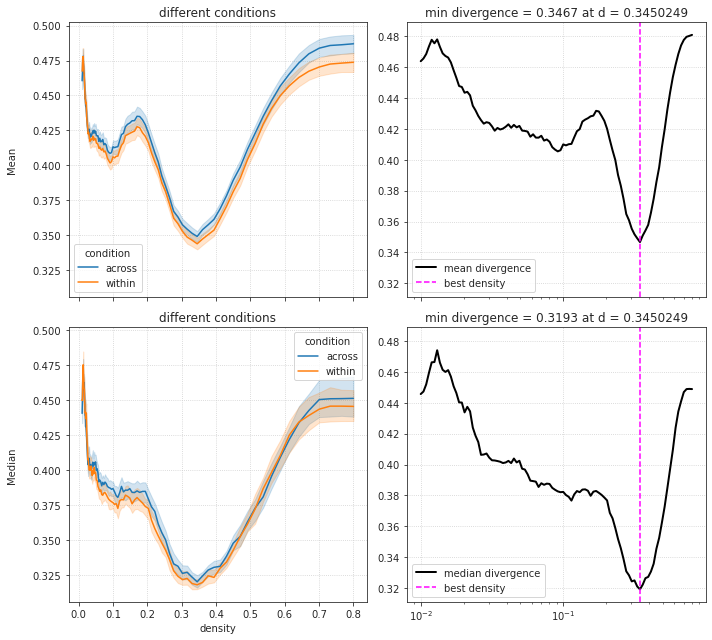

In [15]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df1.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [16]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: bn.nanmean(v) for k, v in across.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: bn.nanmean(v) for k, v in within.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df2 = pd.DataFrame(merge_dicts(dlist))

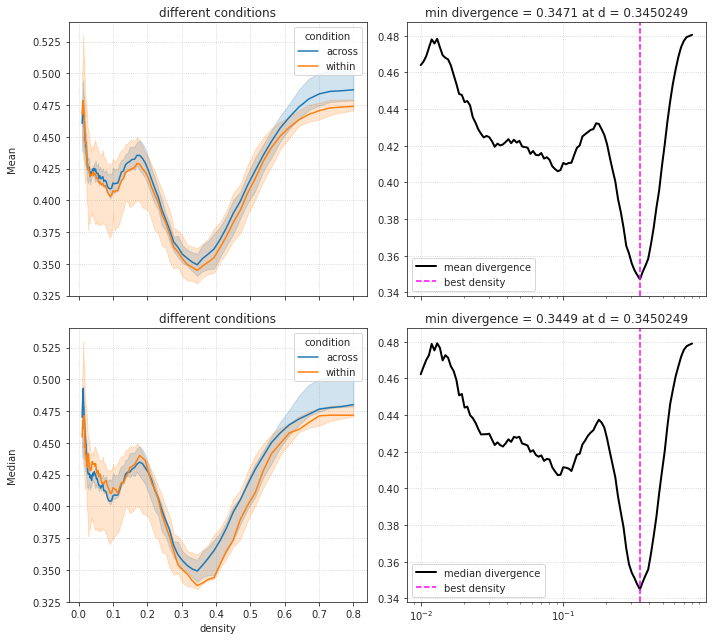

In [17]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df2.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [18]:
df_avg = df1.loc[df1['condition'] == 'within'].groupby(['density']).median()
# df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.345024944381573, 0.3180670062742912)

In [19]:
df_avg = df2.loc[df2['condition'] == 'within'].groupby(['density']).median()
# df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.345024944381573, 0.3377088020033435)

#### tSNE on distance matrix

In [20]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(19, 0.345024944381573)

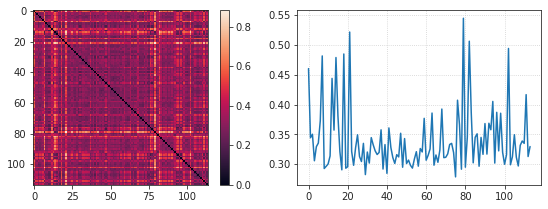

In [21]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(x.mean(0))
axes[1].grid()
plt.show()

In [22]:
bad_runs_bold = np.argsort(x.mean(0))[::-1][:10]
bad_runs_bold = [list(dirs)[i] for i in bad_runs_bold]
bad_runs_bold

[
    'sub-SLC07_ses-3_run-5',
    'sub-SLC02_ses-3_run-5',
    'sub-SLC08_ses-1_run-5',
    'sub-SLC09_ses-3_run-7',
    'sub-SLC02_ses-2_run-5',
    'sub-SLC01_ses-2_run-7',
    'sub-SLC02_ses-1_run-5',
    'sub-SLC01_ses-1_run-1',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC10_ses-3_run-3'
]

In [23]:
from sklearn.manifold import TSNE, MDS

In [24]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [25]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = ses_ids_list

<AxesSubplot:xlabel='x', ylabel='y'>

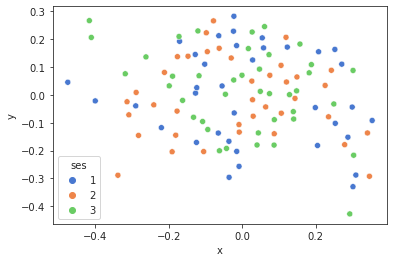

In [26]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

In [27]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [28]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

<AxesSubplot:xlabel='x', ylabel='y'>

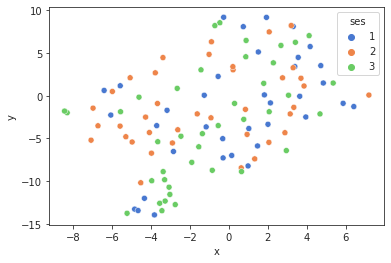

In [29]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

### Ca2

In [30]:
adjacencies, dirs = collect_adjacencies(mice, 'ca2')
adjacencies.shape

(118, 318, 318)

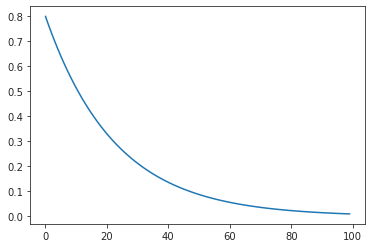

In [31]:
start = 0.80
stop = 0.01
num = 100
densities = np.logspace(np.log10(start), np.log10(stop), num)
plt.plot(densities);

In [32]:
thresholds = np.zeros((len(adjacencies), len(densities)))
for i, a in enumerate(adjacencies):
    thresholds[i] = calculate_threshold(a, densities)

In [34]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portraits)
        (adjacencies[i], thresholds[i], list(dirs.values())[i])
        for i in range(len(adjacencies))
    )

CPU times: user 1.75 s, sys: 3.03 s, total: 4.78 s
Wall time: 1min 30s


In [35]:
portraits = {}
for i, load_dir in enumerate(dirs.values()):
    load_file = pjoin(load_dir, 'portraits.npy')
    port = np.load(load_file, allow_pickle=True).item()
    portraits[i] = list(port.values())

In [36]:
%%time

n_jobs = -1

with joblib.parallel_backend('multiprocessing'):
    div_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(calculate_portrait_divergece)
        ([v[di] for v in portraits.values()])
        for di in range(len(densities))
    )
    
div = np_nans((len(densities), len(adjacencies), len(adjacencies)))
for di in range(len(densities)):
    div[di] = div_list[di]

CPU times: user 1.39 s, sys: 2.95 s, total: 4.34 s
Wall time: 14.2 s


In [37]:
ses_ids_list = []
for key in dirs:
    sub, ses, run = mice.looper[key]
    ses_ids_list.append(ses)
ses_ids = {
    int(ses): np.where(ses_ids_list == ses)[0]
    for ses in np.unique(ses_ids_list)
}

In [38]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = []
    for v in across.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
    
    data = []
    for v in within.values():
        data.extend(list(v))
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'idx': range(len(data)),
        'value': data,
    })
df1 = pd.DataFrame(merge_dicts(dlist))

In [39]:
df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.345024944381573, 0.3299291037839345)

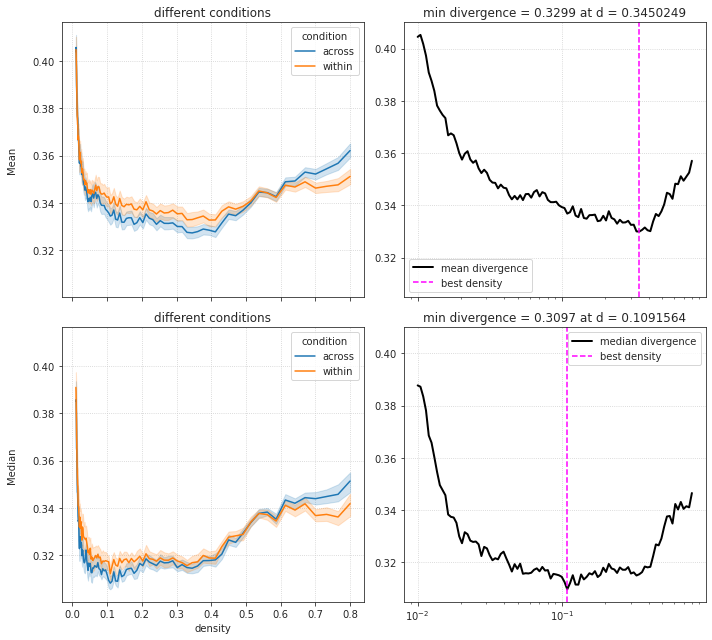

In [40]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df1.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df1.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df1,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [41]:
dlist = []
for di, d in enumerate(densities):
    across = {
        (i, j): div[di][ses_ids[i]][:, ses_ids[j]].ravel()
        for i, j in itertools.combinations(ses_ids, 2)
    }
    within = {
        ses: div[di][ids][:, ids]
        for ses, ids in ses_ids.items()
    }
    within = {
        ses: v[np.triu_indices_from(v, k=1)]
        for ses, v in within.items()
    }
    
    data = {k: bn.nanmean(v) for k, v in across.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['across'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
    
    data = {k: bn.nanmean(v) for k, v in within.items()}
    dlist.append({
        'density': [d] * len(data),
        'condition': ['within'] * len(data),
        'sessions': data.keys(),
        'value': data.values(),
    })
df2 = pd.DataFrame(merge_dicts(dlist))

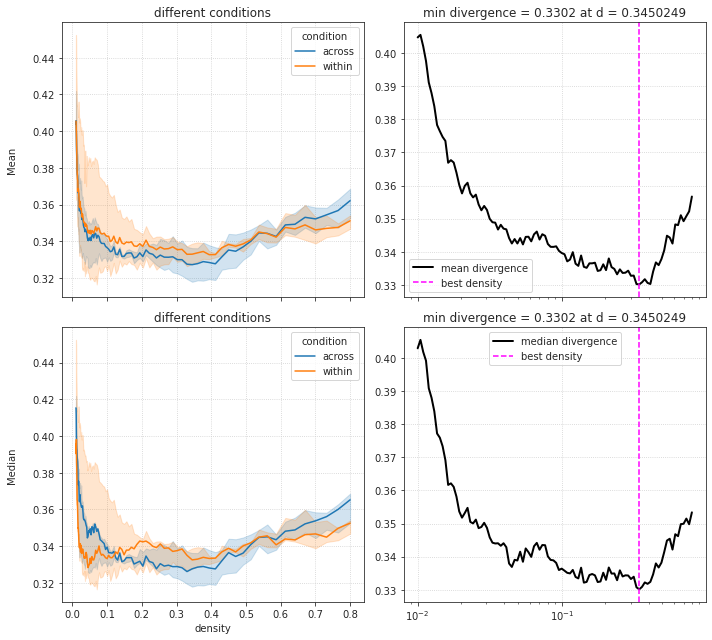

In [42]:
fig, axes = create_figure(2, 2, (10, 9), sharex='col', sharey='col')

df_avg = df2.groupby(['density']).mean()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.mean,
    ax=axes[0, 0],
)
axes[0, 0].set_title("different conditions")
axes[0, 0].grid()

axes[0, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='mean divergence')
axes[0, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[0, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid()


df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]

sns.lineplot(
    data=df2,
    x='density',
    y='value',
    hue='condition',
    estimator=np.median,
    ax=axes[1, 0],
)
axes[1, 0].set_title("different conditions")
axes[1, 0].grid()

axes[1, 1].plot(df_avg.index, df_avg.values, color='k', lw=2, label='median divergence')
axes[1, 1].set_title(f"min divergence = {min_div:0.4f} at d = {best_d:0.7f}")
axes[1, 1].axvline(best_d, color='magenta', ls='--', label='best density')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

axes[0, 0].set_ylabel('Mean\n')
axes[1, 0].set_ylabel('Median\n')

plt.show()

In [43]:
df_avg = df1.loc[df1['condition'] == 'within'].groupby(['density']).median()
# df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.10915636976332257, 0.31202429927288095)

In [44]:
df_avg = df2.loc[df2['condition'] == 'within'].groupby(['density']).median()
# df_avg = df2.groupby(['density']).median()
df_avg = df_avg['value']
best_i = np.argmin(df_avg.values)
best_d, min_div = df_avg.index[best_i], df_avg.values[best_i]
best_d, min_div

(0.045038763639857496, 0.32835964356396047)

#### tSNE on distance matrix

In [45]:
best_di = np.where(densities == best_d)[0].item()
best_di, densities[best_di]

(65, 0.045038763639857496)

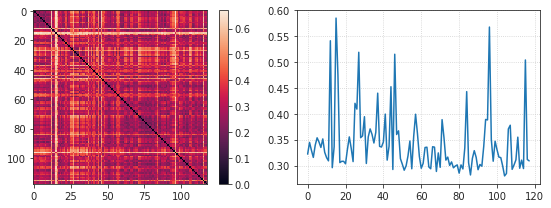

In [46]:
x = div[best_di].copy()
x[np.isnan(x)] = 0.
x += x.T

fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(x)
plt.colorbar(im, ax=axes[0])
axes[1].plot(x.mean(0))
axes[1].grid()
plt.show()

In [47]:
bad_runs_bold = np.argsort(x.mean(0))[::-1][:10]
bad_runs_bold = [list(dirs)[i] for i in bad_runs_bold]
bad_runs_bold

[
    'sub-SLC02_ses-1_run-7',
    'sub-SLC09_ses-1_run-5',
    'sub-SLC02_ses-1_run-1',
    'sub-SLC03_ses-2_run-1',
    'sub-SLC04_ses-3_run-7',
    'sub-SLC10_ses-3_run-3',
    'sub-SLC02_ses-2_run-1',
    'sub-SLC04_ses-3_run-3',
    'sub-SLC08_ses-1_run-3',
    'sub-SLC04_ses-1_run-5'
]

In [48]:
from sklearn.manifold import TSNE, MDS

In [49]:
mds = MDS(n_components=2, dissimilarity='precomputed')
x_emb = mds.fit_transform(x)

In [50]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = ses_ids_list

<AxesSubplot:xlabel='x', ylabel='y'>

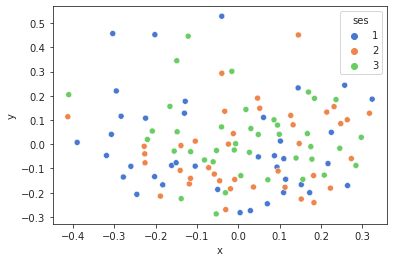

In [51]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')

In [52]:
x_emb = TSNE(
    n_components=2,
    perplexity=20,
    early_exaggeration=10,
    metric='precomputed',
    init='random',
).fit_transform(x)

In [53]:
_df = pd.DataFrame({'x': x_emb[:, 0], 'y': x_emb[:, 1]})
_df['ses'] = [1] * len(ses_ids[1]) + [2] * len(ses_ids[2]) + [3] * len(ses_ids[3])

<AxesSubplot:xlabel='x', ylabel='y'>

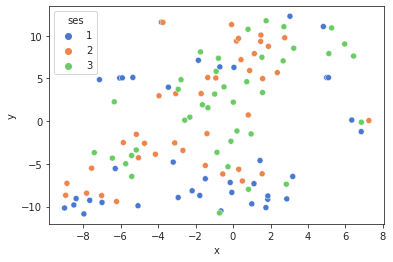

In [54]:
sns.scatterplot(data=_df, x='x', y='y', hue='ses', palette='muted')